# lstm的demo

In [53]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

## define the network

### 原理

<center><img src="lstm.jpg" width="600"></center>


$$
\begin{array}{ll} \\
    i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{t-1} + b_{hi}) \\
    f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{t-1} + b_{hf}) \\
    g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{t-1} + b_{hg}) \\
    o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{t-1} + b_{ho}) \\
    c_t = f_t \odot c_{t-1} + i_t \odot g_t \\
    h_t = o_t \odot \tanh(c_t) \\
\end{array}
$$

> 注：上面的下标是指从什么到什么，比如$W_{ii}$表示从输入到输入的权重，$W_{ig}$表示从输入到门的权重，$W_{hg}$表示从隐藏层到门的权重，$W_{ho}$表示从隐藏层到输出的权重，$W_{hf}$表示从隐藏层到遗忘门的权重，$W_{hi}$表示从隐藏层到输入门的权重。$b_{ii}$表示从输入到输入的偏置，$b_{ig}$表示从输入到门的偏置，$b_{hg}$表示从隐藏层到门的偏置，$b_{ho}$表示从隐藏层到输出的偏置，$b_{hf}$表示从隐藏层到遗忘门的偏置，$b_{hi}$表示从隐藏层到输入门的偏置。$i_t$表示输入门，$f_t$表示遗忘门，$g_t$表示门，$o_t$表示输出门，$c_t$表示记忆单元，$h_t$表示隐藏层。

In [54]:
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()
        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  
        # rnn layer 在自然语言处理中，第一个参数通常是embedding的维度，第二个参数是隐藏层的维度，第三个参数是层数
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim) # y = y.view(seq_len * batch_size, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1) # y = y.view(seq_len, batch_size, out_dim)
        return y

    """
    PyCharm Crtl+click nn.LSTM() jump to code of PyTorch:
    Examples::
        >>> rnn = nn.LSTM(10, 20, 2)
        >>> input = torch.randn(5, 3, 10)
        >>> h0 = torch.randn(2, 3, 20)
        >>> c0 = torch.randn(2, 3, 20)
        >>> output, (hn, cn) = rnn(input, (h0, c0))
    """

    def output_y_hc_for_test(self, x, hc):
        # 后面计算loss的时候，需要用到y和hc，所以这里需要单独写一个函数
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc


### 参数设定

In [55]:
inp_dim = 1 # 输入维度 我们是（reported result）一个维度
out_dim = 1 # 输出维度 我们是预测客流量，所以是1
mid_dim = 10 # 隐藏层维度
mid_layers = 1 # 隐藏层层数
# batch_size = 12 * 4 # 我们划分成48个batch <-- 后面改
batch_size = 32
mod_dir = '.'

### load data

##### for data 1

In [56]:
# import pandas as pd
# # 读取数据
# df = pd.read_csv('df_Number_of_reported_results.csv')
# seq_number = df.values
# # 需要先反转
# seq_number = seq_number[::-1]

##### for data 2

In [57]:
# passengers number of international airline , 1949-01 ~ 1960-12 per month
seq_number = np.array(
    [112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
        118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
        114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
        162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
        209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
        272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
        302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
        315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
        318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
        348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
        362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
        342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
        417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
        432.], dtype=np.float32)
# 给seq_number增加一个维度，变成2维的
seq_number = seq_number[:, np.newaxis]

##### show data

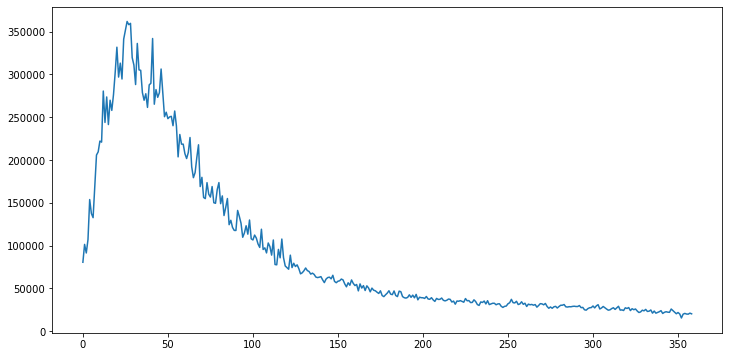

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(seq_number)

In [59]:
seq_number.shape # 1月17号到12月31号的数据，共359天

(359, 1)

In [60]:
seq = seq_number # 所以最终的形式是（当天reported result） 

In [61]:
# 转化成浮点数
seq = seq.astype(np.float32)
seq[:5]

array([[ 80630.],
       [101503.],
       [ 91477.],
       [107134.],
       [153880.]], dtype=float32)

In [62]:
# normalization
seq_mean = seq.mean(axis=0)
seq_std = seq.std(axis=0)
seq_norm = (seq - seq_mean) / seq_std

In [63]:
seq_norm[:5]

array([[-0.11607783],
       [ 0.11818092],
       [ 0.00565861],
       [ 0.18137792],
       [ 0.7060107 ]], dtype=float32)

In [64]:
data = seq_norm 
data_x = data[:-1, :] # 从0到倒数第二个
data_y = data[+1:, 0] # 从1到最后一个
assert data_x.shape[1] == inp_dim
print("data_x[:5]:", data_x[:5])
print("data_y[:5]:", data_y[:5])
print("data_x.shape:", data_x.shape)
print("data_y.shape:", data_y.shape)

data_x[:5]: [[-0.11607783]
 [ 0.11818092]
 [ 0.00565861]
 [ 0.18137792]
 [ 0.7060107 ]]
data_y[:5]: [0.11818092 0.00565861 0.18137792 0.7060107  0.5231423 ]
data_x.shape: (358, 1)
data_y.shape: (358,)


In [65]:
## 2022.2.17到2022.10.29 都是训练集，2022.10.30到2022.12.31都是测试集 也就是一共 497 - 202 + 1 = 296天 
# 296/len(data_x) # <-- for data1

In [66]:
# split train and test
# train_size = 296 # for data1
train_size = int(len(data_x) * 0.70) # 75%的数据作为训练集 for data2

train_x = data_x[:train_size]
train_y = data_y[:train_size]

train_x = train_x.reshape((train_size, inp_dim)) # 296, 1
train_y = train_y.reshape((train_size, out_dim)) # 296, 1
print("train_x.shape: ", train_x.shape)
print("train_y.shape: ", train_y.shape)

train_x.shape:  (250, 1)
train_y.shape:  (250, 1)


### build model

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [68]:
from torchinfo import summary
summary(net, input_size=(batch_size - 1, batch_size, 1))

Layer (type:depth-idx)                   Output Shape              Param #
RegLSTM                                  [31, 32, 1]               --
├─LSTM: 1-1                              [31, 32, 10]              520
├─Sequential: 1-2                        [992, 1]                  --
│    └─Linear: 2-1                       [992, 10]                 110
│    └─Tanh: 2-2                         [992, 10]                 --
│    └─Linear: 2-3                       [992, 1]                  11
Total params: 641
Trainable params: 641
Non-trainable params: 0
Total mult-adds (M): 0.64
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.00
Estimated Total Size (MB): 0.17

### train

#### 制作batch

我们首先制作train的batch，然后训练模型。

制作batch的方法是选取不同开头但截止一样的序列，然后将这些序列组合成一个batch。

<center><img src="lstm_batch.drawio.png" width="600"></center>

##### 制作一个batch

In [69]:
var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

batch_var_x = list()
batch_var_y = list()

for roi_len in range(batch_size):
    begin_idx = train_size - roi_len # train_size = 296
    batch_var_x.append(var_x[begin_idx:])
    batch_var_y.append(var_y[begin_idx:])

In [70]:
# print("var_x.shape: ", var_x.shape)
# print("var_y.shape: ", var_y.shape)
# print("batch_var_x[0].shape: ", batch_var_x[0].shape)
# print("batch_var_y[0].shape: ", batch_var_y[0].shape)
# print("batch_var_x[1].shape: ", batch_var_x[-1].shape)
# print("batch_var_y[1].shape: ", batch_var_y[-1].shape)
# print("batch_var_x.len: ", len(batch_var_x))
# print("batch_var_y.len: ", len(batch_var_y))

##### 制作多个mini_batch使得一个epoch可以看完所有数据

In [71]:
batch_size

32

In [72]:
train_size

250

In [73]:
# # 那么我们大概需要再制作 4个batch就好了，重复是必须的
# var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
# var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

# batch_var_x = list()
# batch_var_y = list()

# mini_batch_size = 5

# for num_of_batch in range(mini_batch_size):
#     end_idx = np.random.randint(batch_size, train_size)
#     for roi_len in range(batch_size):
#         begin_idx = end_idx - roi_len 
#         batch_var_x.append(var_x[begin_idx:end_idx])
#         batch_var_y.append(var_y[begin_idx:end_idx])

In [74]:
# batch_size, mini_batch_size, train_size

In [75]:
# print("var_x.shape: ", var_x.shape)
# print("var_y.shape: ", var_y.shape)
# print("batch_var_x[0].shape: ", batch_var_x[0].shape)
# print("batch_var_y[0].shape: ", batch_var_y[0].shape)
# print("batch_var_x[-1].shape: ", batch_var_x[-1].shape)
# print("batch_var_y[-1].shape: ", batch_var_y[-1].shape)
# print("batch_var_x.len: ", len(batch_var_x))
# print("batch_var_y.len: ", len(batch_var_y))

#### padding

<center><img src="res_img/lstm.drawio.png" width="400"></center>

我们看到不同的batch的shape是不一样的，但是我们需要的是一样的，所以我们需要对batch进行padding，即在后面补0，使得所有的batch的shape都一样

In [76]:
from torch.nn.utils.rnn import pad_sequence
batch_var_x = pad_sequence(batch_var_x)
batch_var_y = pad_sequence(batch_var_y)
print("batch_var_x.shape: ", batch_var_x.shape)
print("batch_var_y.shape: ", batch_var_y.shape)

batch_var_x.shape:  torch.Size([31, 32, 1])
batch_var_y.shape:  torch.Size([31, 32, 1])


> seq_len = 99, example_num = 500, input_size = 1

In [77]:
batch_var_x[:5, 0, :] # 对应上图的蓝色圆角矩形上方第一行数据前五个

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [78]:
batch_var_x[:5, 1, :]  # 对应上图的蓝色圆角矩形所在行数据前五个

tensor([[-0.6899],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000],
        [ 0.0000]])

#### 遗忘曲线控制loss

这里为损失函数添加了类似遗忘曲线的东西，使得模型在训练的时候不会忘记之前的信息，而是会逐渐遗忘。

$$
weight1_{t} = tanh(e * \frac{t}{len(train_y)}) \quad \text{where} \quad t \in [0, len(train_y))
$$

试图改一下遗忘曲线，使得模型在训练的时候对近期记忆保持更多的记忆

$$
weight2_{t} = tanh\left (\alpha * \left (\frac{t}{len(train_y)}-1 \right ) \right )+1 \quad \text{where} \quad t \in [0, len(train_y))
$$

In [79]:
with torch.no_grad():
    weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
    weights = torch.tensor(weights, dtype=torch.float32, device=device)

with torch.no_grad():
    alpha = 10
    weights2 = np.tanh( alpha *(np.arange(len(train_y)) / len(train_y) - 1)) + 1 
    weights2 = torch.tensor(weights2, dtype=torch.float32, device=device)

In [80]:
print("weights.shape: ", weights.shape)

weights.shape:  torch.Size([250])


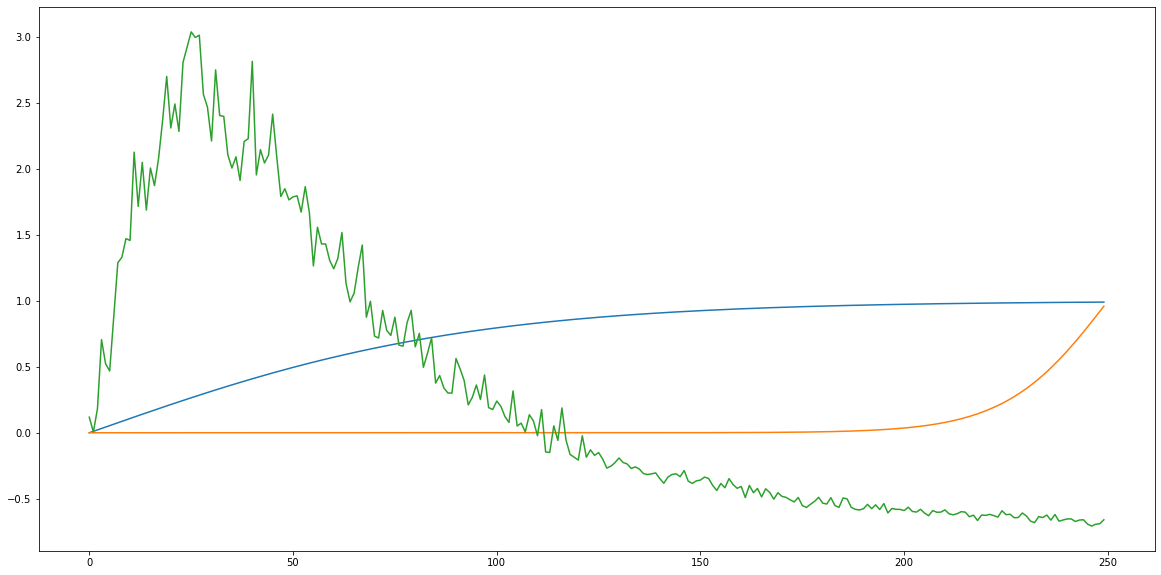

In [81]:
# 画出weights
plt.figure(figsize=(20, 10))
plt.plot(weights.cpu().numpy())
plt.plot(weights2.cpu().numpy())
# 画出客流量
plt.plot(train_y)

#### 开始训练

In [82]:
net.train()
print("Training Start")
num_epochs = 200
train_loss_list = []
for epoch in range(num_epochs):
    out = net(batch_var_x)

    # loss = (out - batch_var_y) ** 2 * weights # <-- 使用weights 
    # loss = (out - batch_var_y) ** 2 * weights2 # <-- 使用weights2 
    # loss = (out - batch_var_y) ** 2 # <-- 不使用weights 

    loss = criterion(out, batch_var_y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # if (epoch+1) % 100 == 0:
    print('Epoch: {:4}, Loss: {:.5f}'.format(epoch, loss.item()))
    train_loss_list.append(loss.item())

Training Start
Epoch:    0, Loss: 0.11437
Epoch:    1, Loss: 0.10250
Epoch:    2, Loss: 0.09983
Epoch:    3, Loss: 0.09781
Epoch:    4, Loss: 0.09246
Epoch:    5, Loss: 0.08534
Epoch:    6, Loss: 0.07835
Epoch:    7, Loss: 0.07219
Epoch:    8, Loss: 0.06601
Epoch:    9, Loss: 0.05805
Epoch:   10, Loss: 0.04772
Epoch:   11, Loss: 0.03662
Epoch:   12, Loss: 0.02744
Epoch:   13, Loss: 0.02068
Epoch:   14, Loss: 0.01458
Epoch:   15, Loss: 0.01183
Epoch:   16, Loss: 0.01708
Epoch:   17, Loss: 0.02002
Epoch:   18, Loss: 0.01837
Epoch:   19, Loss: 0.01562
Epoch:   20, Loss: 0.01113
Epoch:   21, Loss: 0.00710
Epoch:   22, Loss: 0.00551
Epoch:   23, Loss: 0.00554
Epoch:   24, Loss: 0.00607
Epoch:   25, Loss: 0.00691
Epoch:   26, Loss: 0.00761
Epoch:   27, Loss: 0.00759
Epoch:   28, Loss: 0.00694
Epoch:   29, Loss: 0.00611
Epoch:   30, Loss: 0.00518
Epoch:   31, Loss: 0.00411
Epoch:   32, Loss: 0.00326
Epoch:   33, Loss: 0.00294
Epoch:   34, Loss: 0.00296
Epoch:   35, Loss: 0.00309
Epoch:   36, 

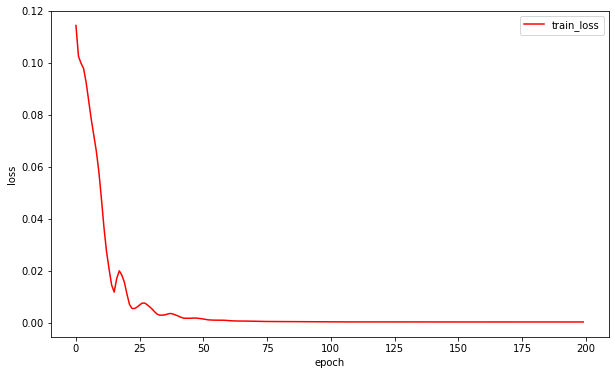

In [83]:
# 画图
plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, label='train_loss', color='r')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

保存参数

In [84]:
# torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
# print("Save in:", '{}/net.pth'.format(mod_dir))

In [105]:
# 加载模型
net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
params = torch.load('{}/net.pth'.format(mod_dir))
net.load_state_dict(params)

RuntimeError: Error(s) in loading state_dict for RegLSTM:
	size mismatch for rnn.weight_ih_l0: copying a param with shape torch.Size([32, 3]) from checkpoint, the shape in current model is torch.Size([40, 1]).
	size mismatch for rnn.weight_hh_l0: copying a param with shape torch.Size([32, 8]) from checkpoint, the shape in current model is torch.Size([40, 10]).
	size mismatch for rnn.bias_ih_l0: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for rnn.bias_hh_l0: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([40]).
	size mismatch for reg.0.weight: copying a param with shape torch.Size([8, 8]) from checkpoint, the shape in current model is torch.Size([10, 10]).
	size mismatch for reg.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([10]).
	size mismatch for reg.2.weight: copying a param with shape torch.Size([1, 8]) from checkpoint, the shape in current model is torch.Size([1, 10]).

### eval

制作test set

In [86]:
test_x = seq_norm.copy() 
test_x[train_size:, 0] = 0 # 设置为0，表示预测 
test_x = test_x[:, np.newaxis, :] 
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)
print("test_x.shape: ", test_x.shape)

test_x.shape:  torch.Size([359, 1, 1])


In [87]:
# net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
net.eval()

RegLSTM(
  (rnn): LSTM(1, 10)
  (reg): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [88]:
with torch.no_grad():
    '''simple way is elegant'''
    # for i in range(train_size, len(data)):
    #     test_y = net(test_x[:i])
    #     test_x[i, 0, 0] = test_y[-1]

    eval_size = 1
    zero_ten = torch.zeros((mid_layers, eval_size, mid_dim), dtype=torch.float32, device=device)
    test_y, hc = net.output_y_hc_for_test(test_x[:train_size], (zero_ten, zero_ten))
    test_x[train_size + 1, 0, 0] = test_y[-1]
    for i in range(train_size + 1, len(data) - 2):
        test_y, hc = net.output_y_hc_for_test(test_x[i:i + 1], hc)
        test_x[i + 1, 0, 0] = test_y[-1]


    pred_y = test_x[1:, 0, 0]
    pred_y = pred_y.cpu().data.numpy()

    diff_y = pred_y[train_size:] - data_y[train_size:]
    l2_loss = np.mean(diff_y ** 2)
    print(" test mse loss: ", l2_loss)

 test mse loss:  0.027146576


##### for data 1

In [89]:
# origin_data = df.values
# # 反转
# origin_data = origin_data[::-1]

##### for data 2

In [90]:
origin_data = seq.copy()

In [91]:
print("pred_y.shape: ", pred_y.shape)
print("data_y.shape: ", data_y.shape)
print("the last pred_y: ", pred_y[-1])
print("the last data_y: ", data_y[-1])


pred_y.shape:  (358,)
data_y.shape:  (358,)
the last pred_y:  0.0
the last data_y:  -0.79226667


##### 数据还原

In [92]:
mean = origin_data.mean()
std = origin_data.std()
print("mean: ", mean)
print("std: ", std)

# 将预测值还原
pred_y = pred_y * std + mean
# 设置成int类型
pred_y = pred_y.astype(int)

mean:  90972.805
std:  89102.33


##### 求MSE (Mean Squared Error)

In [93]:
# 先对pred_y添加一个维度
pred_y = pred_y[:, np.newaxis]

In [94]:
origin_data.shape , pred_y.shape

((359, 1), (358, 1))

In [95]:
# 在pred_y之前添加origin_data的第一个元
pred_y = np.insert(pred_y, 0, origin_data[0], axis=0)

In [96]:
origin_data[0]

array([80630.], dtype=float32)

In [97]:
origin_data.shape , pred_y.shape

((359, 1), (359, 1))

In [98]:
# 和真实值对比求误差
diff_y = pred_y[train_size:] - origin_data[train_size:]
l2_loss = np.mean(diff_y ** 2)
print(" test mse loss: ", l2_loss)

 test mse loss:  245307753.33944955


In [99]:
# 计算R square
from sklearn.metrics import r2_score
r2 = r2_score(origin_data[:train_size], pred_y[:train_size])
print("R square: ", r2)

R square:  0.999999999993653


##### 预测曲线图

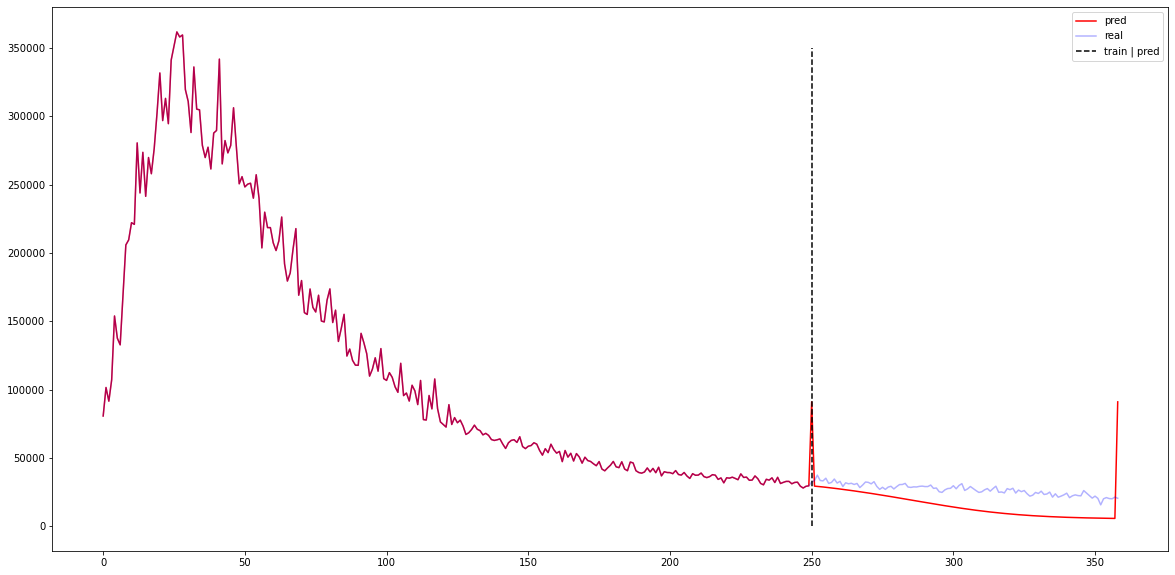

In [100]:
plt.figure(figsize=(20,10))
plt.plot(pred_y, 'r', label='pred')
plt.plot(origin_data, 'b', label='real', alpha=0.3)
plt.plot([train_size, train_size], [0, 350000], color='k', label='train | pred', linestyle='--')
# plt.plot([train_size, train_size], [0, 200], color='k', label='train | pred', linestyle='--')
plt.legend(loc='best')
# plt.savefig('pred_with_regularization_batch_lstm1.png')

#### 长期预测

In [101]:
pred_result = seq_norm.copy()
pred_result = np.concatenate((pred_result, np.zeros((60, 1))), axis=0)
pred_result[train_size:, 0] = 0 # 设置为0，表示预测 
pred_result = pred_result[:, np.newaxis, :] 
pred_result = torch.tensor(pred_result, dtype=torch.float32, device=device)

with torch.no_grad():
    '''simple way is elegant'''
    for i in range(train_size, len(data)+60):
        test_y = net(pred_result[:i])
        pred_result[i, 0, 0] = test_y[-1]

    pred_y = pred_result[1:, 0, 0]
    pred_y = pred_y.cpu().data.numpy()

In [102]:
# 还原
pred_y = pred_y * std + mean
pred_y = pred_y.astype(int)
pred_y = pred_y[:, np.newaxis]
pred_y = np.insert(pred_y, 0, origin_data[0], axis=0)

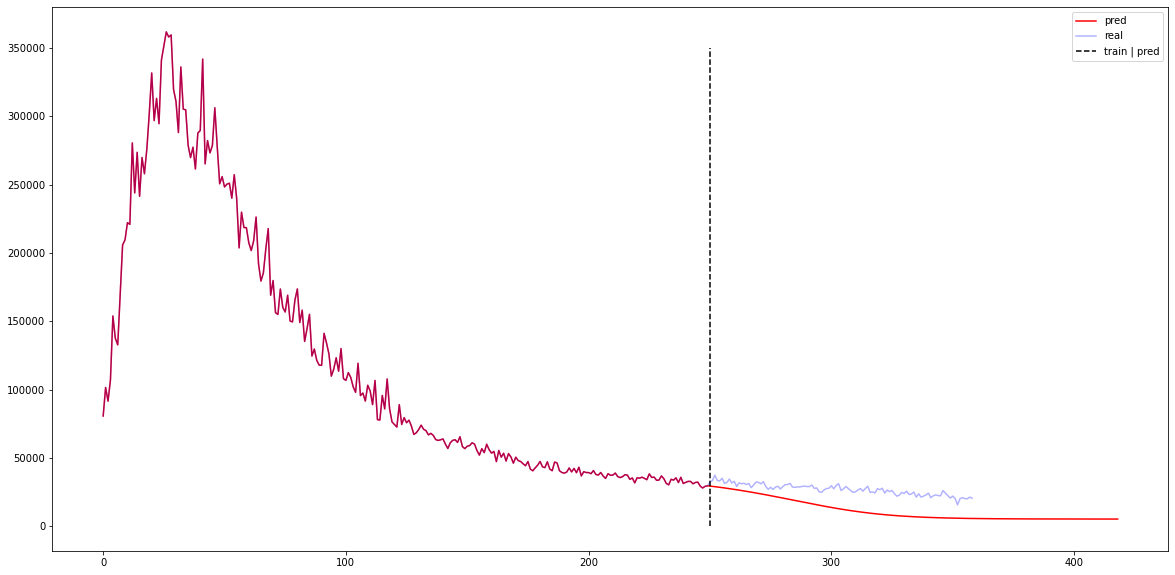

In [103]:
plt.figure(figsize=(20,10))
plt.plot(pred_y, 'r', label='pred')
plt.plot(origin_data, 'b', label='real', alpha=0.3)
# plt.plot([train_size, train_size], [0, 200], color='k', label='train | pred', linestyle='--')
plt.plot([train_size, train_size], [0, 350000], color='k', label='train | pred', linestyle='--')
plt.legend(loc='best')
# plt.savefig('pred_with_weight2_alpha_' + str(alpha) + '.png')
# plt.savefig('pred_with_no_weight_batchsize_' + str(batch_size) + '.png')

In [104]:
print("pred_y.shape: ", pred_y.shape)
print("final pred_y: ", pred_y[-1])

pred_y.shape:  (419, 1)
final pred_y:  [5155]


In [106]:
# 保存pred_y到excel df['Date']做为索引
import pandas as pd
df = pd.DataFrame(pred_y)
df.to_excel('pred_y.xlsx', index=False)

### 总计改进

由上面可以发现不加weights训练效果是最好的，我们多次进行不加weights的训练查看效果。

我们下一步可以做的工作有，
- 制作mini_batch，训练更多的数据而不是只有我们训练的一个batch而已
- 重新确定好训练集和测试集的比例分割数据